Phase B - Exploration + Data preprocessing

* Reads multiple CSV files.
* Converts the "checkin" and "checkout" columns to datetime.
* Adds a "group_index" column to preserve the order of appearance within each (checkin, checkout) combination.
* Merges the individual DataFrames into a single DataFrame (df_all) and saves it to a new CSV file.

In [150]:
import pandas as pd
from datetime import datetime

# List the CSV files (update paths if needed)
csv_files = [
    "booking_com_20250310.csv",
    "booking_com_20250312.csv",
    "booking_com_20250317.csv"
]

df_list = []
for file in csv_files:
    print(f"Processing file: {file}")
    df = pd.read_csv(file)
    
    # Convert checkin and checkout to datetime (if they are not already)
    df["checkin"] = pd.to_datetime(df["checkin"])
    df["checkout"] = pd.to_datetime(df["checkout"])
    
    # Assuming rows in each file are in the order they appeared on the website,
    # add a group index within each (checkin, checkout) combination.
    df["group_index"] = df.groupby(["checkin", "checkout"]).cumcount() + 1
    df_list.append(df)

# Merge all DataFrames into one
df_all = pd.concat(df_list, ignore_index=True)

# Optionally sort by checkin, checkout and group_index (to maintain overall order)
df_all = df_all.sort_values(by=["checkin", "checkout", "group_index"]).reset_index(drop=True)

# Save the merged DataFrame to a new CSV file
output_filename = "merged_booking.csv"
df_all.to_csv(output_filename, index=False)
print(f"Merged data saved to {output_filename}")

# Display the first few rows to verify
df_all.head()


Processing file: booking_com_20250310.csv
Processing file: booking_com_20250312.csv
Processing file: booking_com_20250317.csv
Merged data saved to merged_booking.csv


,hotel_name,star_rating,rating_score,location_score,review_amount,bed_info,price,breakfast_included,free_cancellation,no_prepayment_needed,centrally_located,sustainability_certification,distance_from_downtown,checkin,checkout,group_index
0,Roxy Hotel New York,4.0,8.6,9.3,1145.0,1 king bed,"₪ 1,450",False,False,False,True,False,5.8 km from downtown,2025-03-10,2025-03-11,1
1,Riu Plaza Manhattan Times Square,4.0,8.7,9.6,13232.0,1 king bed,"₪ 1,001",False,False,True,True,True,NaN,2025-03-10,2025-03-11,2
2,UNTITLED at 3 Freeman Alley,4.0,8.5,NaN,592.0,1 queen bed,₪ 883,False,False,False,True,False,5.2 km from downtown,2025-03-10,2025-03-11,3
3,Aura Hotel Times Square Newly Renovated,4.0,7.7,9.4,507.0,1 full bed,₪ 942,False,False,False,True,False,NaN,2025-03-10,2025-03-11,4
4,Sonder at One Platt,4.0,8.2,NaN,1908.0,NaN,₪ 802,False,False,False,True,False,7 km from downtown,2025-03-10,2025-03-11,5


* Displays descriptive statistics (using describe()) for the price, rating score, and review amount.
* Plots histograms for each of these metrics to visualize their distributions.

Price statistics BEFORE outlier removal:
count     45387.000000
mean       4038.467887
std        2580.357414
min         343.000000
25%        2148.500000
50%        3730.000000
75%        5464.000000
max      146615.000000
Name: price_numeric, dtype: float64

Rating score statistics:
count    45374.000000
mean         8.059505
std          0.576362
min          5.200000
25%          7.700000
50%          8.100000
75%          8.500000
max          9.600000
Name: rating_score, dtype: float64

Review amount statistics:
count    45346.000000
mean      3736.386760
std       3965.093552
min          1.000000
25%       1468.000000
50%       2261.000000
75%       4190.000000
max      23140.000000
Name: review_amount, dtype: float64


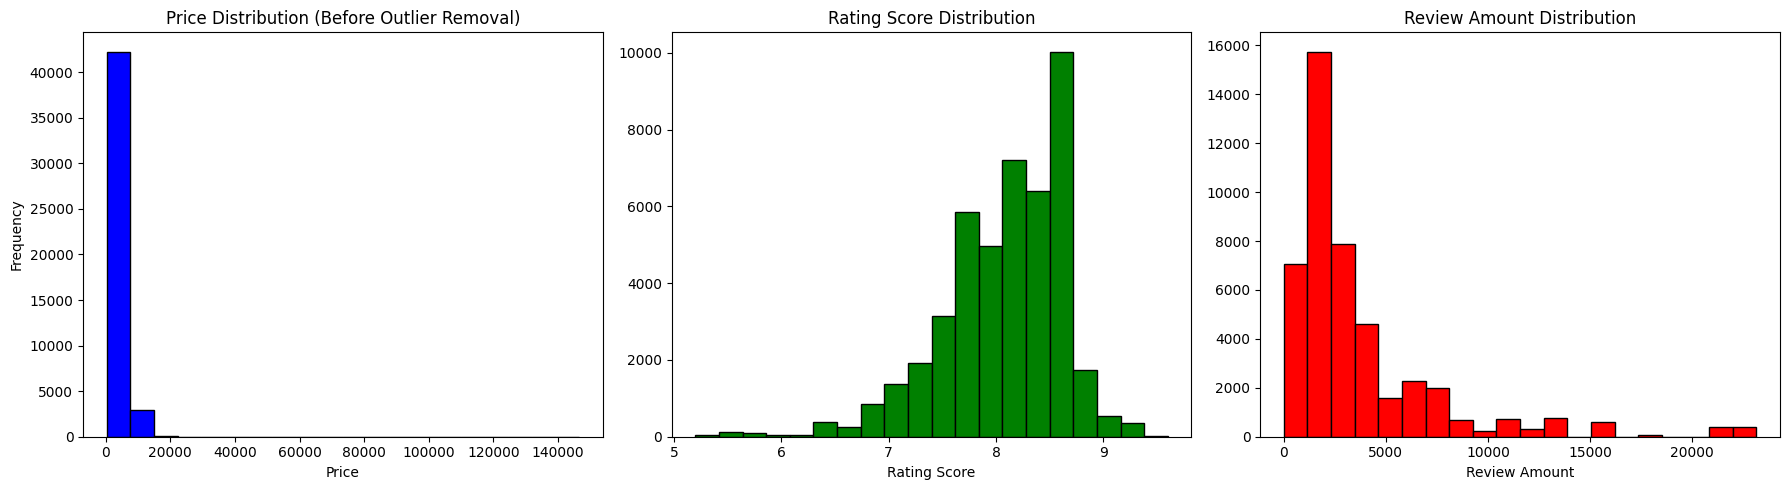

In [151]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure the cleaned numeric price column exists.
if "price_numeric" not in df_all.columns:
    df_all["price_clean"] = (
        df_all["price"]
        .str.replace("₪", "", regex=False)
        .str.replace(",", "", regex=False)
        .str.strip()
    )
    df_all["price_numeric"] = pd.to_numeric(df_all["price_clean"], errors="coerce")

# Display descriptive statistics for the numeric columns
print("Price statistics BEFORE outlier removal:")
print(df_all["price_numeric"].describe())

print("\nRating score statistics:")
print(df_all["rating_score"].describe())

print("\nReview amount statistics:")
print(df_all["review_amount"].describe())

# Plot histograms for Price, Rating Score, and Review Amount
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(df_all["price_numeric"].dropna(), bins=20, color="blue", edgecolor="black")
axes[0].set_title("Price Distribution (Before Outlier Removal)")
axes[0].set_xlabel("Price")
axes[0].set_ylabel("Frequency")

axes[1].hist(df_all["rating_score"].dropna(), bins=20, color="green", edgecolor="black")
axes[1].set_title("Rating Score Distribution")
axes[1].set_xlabel("Rating Score")

axes[2].hist(df_all["review_amount"].dropna(), bins=20, color="red", edgecolor="black")
axes[2].set_title("Review Amount Distribution")
axes[2].set_xlabel("Review Amount")

plt.tight_layout()
plt.show()


* Checks for and creates a cleaned numeric price column (price_numeric) from the original "price" column (removing currency symbols and commas).
* Computes Q1, Q3, and the IQR, and defines lower and upper bounds using Tukey’s method (1.5 * IQR).
* Filters out rows with price_numeric values outside these bounds.
* Displays descriptive statistics and histograms for the filtered data (price, rating score, review amount).

Tukey's Method for Price Outlier Removal:
Q1 = 2148.5
Q3 = 5464.0
IQR = 3315.5
Lower Bound = -2824.75
Upper Bound = 10437.25

Price statistics AFTER Tukey outlier removal:
count    44771.000000
mean      3900.485247
std       2141.329293
min        343.000000
25%       2122.000000
50%       3685.000000
75%       5381.000000
max      10430.000000
Name: price_numeric, dtype: float64

Rating score statistics (filtered):
count    44748.000000
mean         8.056595
std          0.576984
min          5.200000
25%          7.700000
50%          8.100000
75%          8.500000
max          9.600000
Name: rating_score, dtype: float64

Review amount statistics (filtered):
count    44720.000000
mean      3756.645662
std       3977.677437
min          1.000000
25%       1470.000000
50%       2334.000000
75%       4191.000000
max      23140.000000
Name: review_amount, dtype: float64


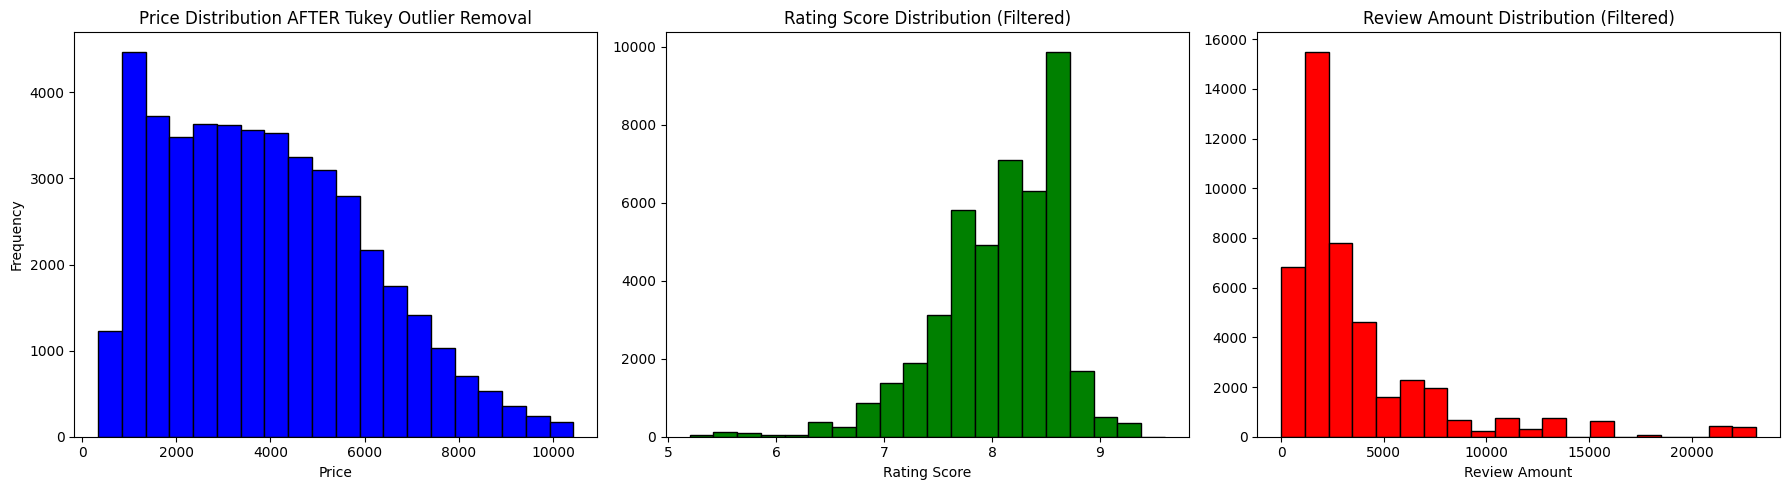

In [152]:
# If "price_numeric" does not exist, create it from the "price" column
if "price_numeric" not in df_all.columns:
    df_all["price_clean"] = (
        df_all["price"]
        .str.replace("₪", "", regex=False)
        .str.replace(",", "", regex=False)
        .str.strip()
    )
    df_all["price_numeric"] = pd.to_numeric(df_all["price_clean"], errors="coerce")

import matplotlib.pyplot as plt

# Calculate Q1, Q3, and IQR for the cleaned numeric price data
Q1 = df_all["price_numeric"].quantile(0.25)
Q3 = df_all["price_numeric"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Tukey's Method for Price Outlier Removal:")
print("Q1 =", Q1)
print("Q3 =", Q3)
print("IQR =", IQR)
print("Lower Bound =", lower_bound)
print("Upper Bound =", upper_bound)

# Filter the DataFrame based on the Tukey bounds for price_numeric
df_tukey = df_all[(df_all["price_numeric"] >= lower_bound) & (df_all["price_numeric"] <= upper_bound)]

print("\nPrice statistics AFTER Tukey outlier removal:")
print(df_tukey["price_numeric"].describe())

print("\nRating score statistics (filtered):")
print(df_tukey["rating_score"].describe())

print("\nReview amount statistics (filtered):")
print(df_tukey["review_amount"].describe())

# Plot histograms for Price, Rating Score, and Review Amount using the filtered DataFrame
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(df_tukey["price_numeric"].dropna(), bins=20, color="blue", edgecolor="black")
axes[0].set_title("Price Distribution AFTER Tukey Outlier Removal")
axes[0].set_xlabel("Price")
axes[0].set_ylabel("Frequency")

axes[1].hist(df_tukey["rating_score"].dropna(), bins=20, color="green", edgecolor="black")
axes[1].set_title("Rating Score Distribution (Filtered)")
axes[1].set_xlabel("Rating Score")

axes[2].hist(df_tukey["review_amount"].dropna(), bins=20, color="red", edgecolor="black")
axes[2].set_title("Review Amount Distribution (Filtered)")
axes[2].set_xlabel("Review Amount")

plt.tight_layout()
plt.show()


* Extracts and prints sorted unique values from the bed_info column.
* Extracts and prints sorted unique values from the distance_from_downtown column.

In [153]:
# Unique values in the 'bed_info' column
unique_bed_info = df_all["bed_info"].dropna().unique()
unique_bed_info_sorted = sorted(unique_bed_info)
print("Unique 'bed_info' values:")
for val in unique_bed_info_sorted:
    print(val)

print("\n" + "-"*40 + "\n")

# Unique values in the 'distance_from_downtown' column
unique_distance = df_all["distance_from_downtown"].dropna().unique()
unique_distance_sorted = sorted(unique_distance)
print("Unique 'distance_from_downtown' values:")
for val in unique_distance_sorted:
    print(val)


Unique 'bed_info' values:
1 bunk bed
1 full bed
1 king bed
1 king bed • Free crib always available
1 queen bed
1 queen bed • Free crib always available
1 twin bed
2 beds (1 full, 1 sofa bed)
2 beds (1 king, 1 queen)
2 beds (1 king, 1 sofa bed)
2 beds (1 sofa bed, 1 queen)
2 beds (1 twin, 1 full)
2 beds (1 twin, 1 king)
2 beds (1 twin, 1 queen)
2 bunk beds
2 full beds
2 king beds
2 queen beds
2 twin beds
3 beds (1 bunk bed, 2 queens)
3 beds (1 sofa bed, 2 queens)
3 beds (2 fulls, 1 sofa bed)
4 twin beds
8 beds (2 twins, 4 fulls, 2 queens)
8 beds (3 twins, 2 fulls, 1 king, 2 queens)
Beds: 1 double or 2 twins
Entire apartment • 1 kitchen • 55 m²
Entire apartment • 1 kitchen • 55m²
Entire apartment • 1 kitchen • 57 m²
Entire apartment • 1 kitchen • 57m²
Multiple bed types

----------------------------------------

Unique 'distance_from_downtown' values:
0.5 km from downtown
0.6 km from downtown
0.7 km from downtown
0.8 km from downtown
0.9 km from downtown
1 km from downtown
1.1 km from do

Bed Mapping:
* Extracts a weighted “bed score” (bed_score) from the bed_info string.
* Uses weights to reflect bed quality (e.g., king beds score higher than queen, full, or twin beds) and adds a bonus if a free crib is mentioned.

Distance Mapping:
* Converts the distance_from_downtown string to a numeric value in kilometers.
* Assigns an ordinal score (distance_score) on a 1–5 scale, with higher scores for closer distances (e.g., 5 for <1 km, down to 1 for ≥4 km).
* Drops the original bed_info, distance_from_downtown, and intermediate distance_km columns so that only the processed columns remain.
* Prints unique values for bed_score and distance_score and displays a few sample rows for verification.

In [154]:
import re
import numpy as np
import pandas as pd

# --- Bed Info Mapping ---
# This function parses the bed_info string to compute a weighted "bed_score".
# It uses a weight mapping for bed types (king > queen > full/double > twin > sofa > bunk).
# It also adds a bonus if a free crib is mentioned.
def compute_bed_score(bed_str):
    if not isinstance(bed_str, str):
        return 0  # Default to 0 if no valid string is provided
    bed_str_lower = bed_str.lower()
    
    # Define weights for different bed types.
    bed_weights = {
        "king": 4,
        "queen": 3,
        "full": 2,
        "double": 2,  # treat double as equivalent to full
        "twin": 1,
        "sofa": 1.5,  # for sofa beds
        "bunk": 0.5   # bunk beds score lower
    }
    
    # Use regex to find all patterns like "1 king bed", "2 queen beds", etc.
    pattern = r"(\d+)\s*([a-z\s]+?)\s*bed"
    matches = re.findall(pattern, bed_str_lower)
    total_score = 0
    total_count = 0
    for count_str, bed_type in matches:
        try:
            count = int(count_str)
        except:
            continue
        weight = 0
        # Check for each key in our mapping within the bed type string.
        for key, val in bed_weights.items():
            if key in bed_type:
                weight = val
                break
        total_score += count * weight
        total_count += count

    # Compute the average score if any beds were found, else default to 0.
    avg_score = total_score / total_count if total_count > 0 else 0

    # Add a bonus if a free crib is mentioned
    if "crib" in bed_str_lower:
        avg_score += 0.5

    return avg_score

# Create a new column 'bed_score' from 'bed_info'
df_all["bed_score"] = df_all["bed_info"].apply(compute_bed_score)

# --- Distance Mapping ---
# Convert a distance string (e.g., "0.5 km from downtown" or "300 m from downtown") to kilometers.
def convert_distance_to_km(distance_str):
    if not isinstance(distance_str, str):
        return np.nan
    distance_str = distance_str.strip()
    if "km" in distance_str:
        match = re.search(r"([\d\.]+)\s*km", distance_str)
        if match:
            return float(match.group(1))
    elif "m" in distance_str:
        match = re.search(r"([\d\.]+)\s*m", distance_str)
        if match:
            return float(match.group(1)) / 1000.0
    return np.nan

# Create a new column 'distance_km' from 'distance_from_downtown'
df_all["distance_km"] = df_all["distance_from_downtown"].apply(convert_distance_to_km)

# Score the numeric distance: if the hotel is centrally located, assign maximum score.
def score_distance_row(row):
    # If the hotel is marked as centrally located, give maximum score (5).
    if row.get("centrally_located", False):
        return 5
    distance = row.get("distance_km", np.nan)
    if pd.isna(distance):
        return 1  # If missing, assign the lowest score.
    if distance < 1:
        return 5
    elif distance < 2:
        return 4
    elif distance < 3:
        return 3
    elif distance < 4:
        return 2
    else:
        return 1

# Create a new column 'distance_score' using the row-wise function.
df_all["distance_score"] = df_all.apply(score_distance_row, axis=1)

# --- Drop original columns ---
df_all = df_all.drop(columns=["bed_info", "distance_from_downtown", "distance_km"])

# --- Inspection ---
print("Unique bed_score values:")
print(sorted(df_all["bed_score"].dropna().unique()))

print("\nUnique distance_score values:")
print(sorted(df_all["distance_score"].dropna().unique()))

print("\nSample rows:")
df_all.sample(n=3)


Unique bed_score values:
[np.float64(0.0), np.float64(0.125), np.float64(0.375), np.float64(0.5), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(3.5), np.float64(4.0), np.float64(4.5)]

Unique distance_score values:
[np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]

Sample rows:


,hotel_name,star_rating,rating_score,location_score,review_amount,price,breakfast_included,free_cancellation,no_prepayment_needed,centrally_located,sustainability_certification,checkin,checkout,group_index,price_clean,price_numeric,bed_score,distance_score
28521,ModernHaus SoHo,5.0,8.2,NaN,1051.0,"₪ 7,200",False,True,True,False,True,2025-04-01,2025-04-05,8,7200,7200.0,3.0,1
36646,Millennium Downtown New York,4.0,7.2,NaN,5326.0,"₪ 1,654",False,False,False,False,True,2025-04-07,2025-04-08,83,1654,1654.0,4.0,1
11736,The Chelsean New York,3.0,7.0,NaN,2897.0,"₪ 2,682",False,True,False,False,False,2025-03-21,2025-03-23,13,2682,2682.0,2.0,3


* Extracting the proccesed data to a new csv file

In [155]:
output_filename = "merged_booking_final.csv"
df_all.to_csv(output_filename, index=False)
print(f"DataFrame saved to {output_filename}")


DataFrame saved to merged_booking_final.csv


* Plotting the PairGrid

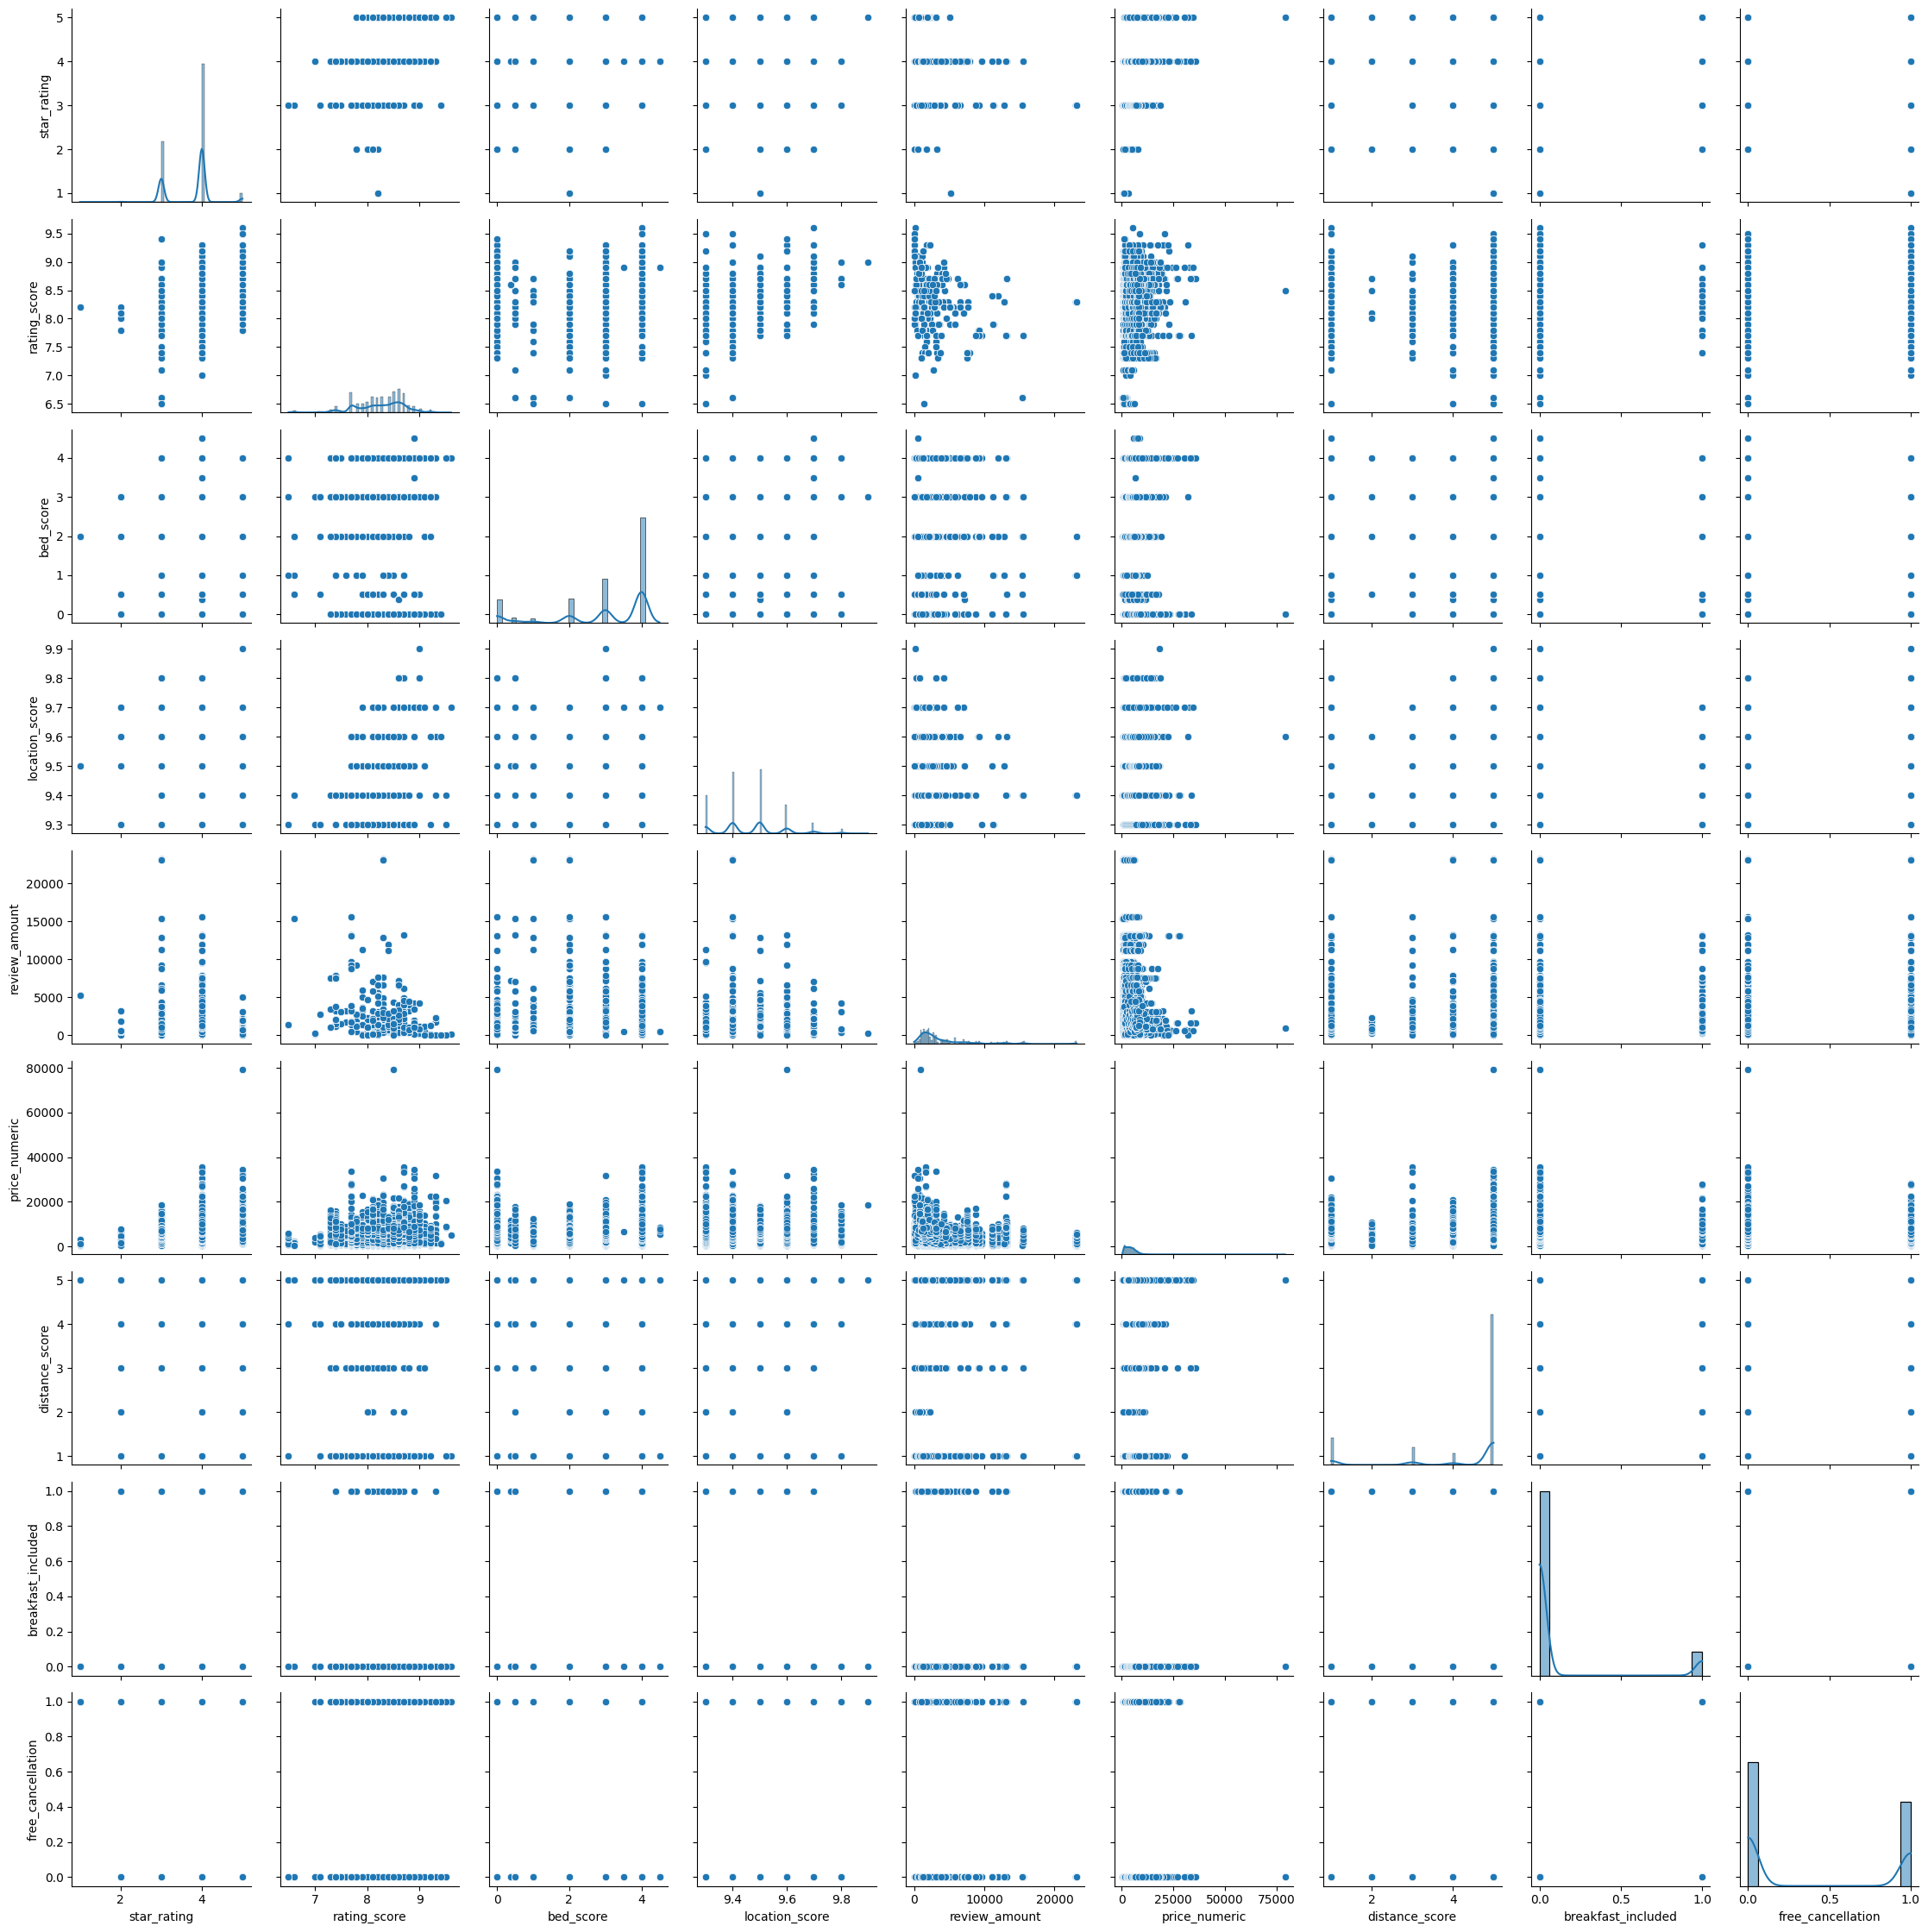

In [165]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of numeric columns to visualize; adjust as necessary.
numeric_cols = ["star_rating", "rating_score", "bed_score", "location_score", "review_amount", "price_numeric", "distance_score", "breakfast_included", "free_cancellation"]

# Create a PairGrid using these columns.
grid = sns.PairGrid(df_all[numeric_cols].dropna())
grid.map_diag(sns.histplot, kde=True)  # On the diagonal: histogram with KDE
grid.map_offdiag(sns.scatterplot)      # Off the diagonal: scatterplots

plt.tight_layout()
plt.show()


**Reviews and Price:**

 There's a positive relationship between the number of reviews and price - hotels with more reviews tend to be more expensive, possibly indicating more popular or established properties command higher prices.

**Rating and Price:**

 There's a correlation between rating and price, with higher-rated hotels generally charging more. The vertical striping pattern shows that certain rating categories (like 4-5) have wider price ranges than others.

**Rating and Distance:**

 There's a correlation between rating and distance, with higher-rated hotels generally located close to the downtown area, indicating that distance from high value areas are critical for a good rating.

**Rooms Left and Price:**

 There's an interesting relationship showing that lower inventory (fewer rooms left) tends to correlate with higher prices, supporting the dynamic pricing model hotels use.

**Breakfast and Price:**

 Hotels offering breakfast are generally cheaper, perhaps trying to lure customers with benefits due to low demand.

**Free Cancellation and Price:**

 Same conclution as free breakfast benefit: Hotels offering free cancelation are generally cheaper, perhaps trying to lure customers with benefits due to low demand.
